# Prueba de ajuste de un modelo. 

In [44]:
import numpy as np
import math
import matplotlib. pyplot as plt
import scipy.optimize as op
import emcee
import corner

## El modelo generativo probabilístico.

Escojemos los paramestros reales:

In [19]:
m_true = -0.9594
b_true = 4.294
f_true = 0.534

Ll primer paso generalmente es anotar likelihood (la probabilidad de un conjunto de datos dados los parámetros del modelo). En este caso, vamos a considerar un modelo lineal donde las incertidumbres citadas se subestiman por una cantidad fraccionaria constante.

Genera algunos datos sinteticos del modelo

In [20]:
N = 50
x = np.sort(10*np.random.rand(N)) #Acomoda el arreglo de mínimo a máximo
yerr = 0.1 + 0.5*np.random.rand(N)
y = m_true*x+b_true
y = y + np.abs(f_true*y) * np.random.randn(N)
y = y + yerr * np.random.randn(N)

Hacemos la grafica de la recta ajustada:

In [21]:
X0 = np.linspace(np.amin(x),np.amax(x))
Y0 = m_true*X0 + b_true

GRAFICA:

El modelo verdadero se muestra como una línea gris y las incertidumbres lo rodean. 

<Figure size 432x288 with 0 Axes>

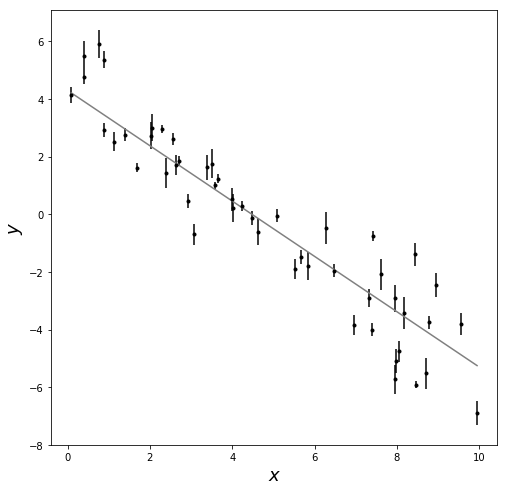

In [22]:
plt.figure(1)
plt.figure(figsize=(8,8))
plt.xlabel('$x$',fontsize = 18)
plt.ylabel('$y$',fontsize = 18)
plt.errorbar(x, y, yerr=yerr, color='0' ,fmt=".k")
plt.plot(X0,Y0,color='0.5')

La solución lineal de mínimos cuadrados para estos datos es:

In [23]:
A = np.vstack((np.ones_like(x), x)).T #concatena 1 cadenas de tamaño len(x) y se transpone.
C = np.diag(yerr * yerr) # acomoda en un arreglo donde y*y es la diagonal.
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y)))

In [51]:
print 'm = {!r}.'.format(m_ls)
print 'b = {!r}.'.format(b_ls)

m = -1.065529816467211.
b = 4.702205737731504.


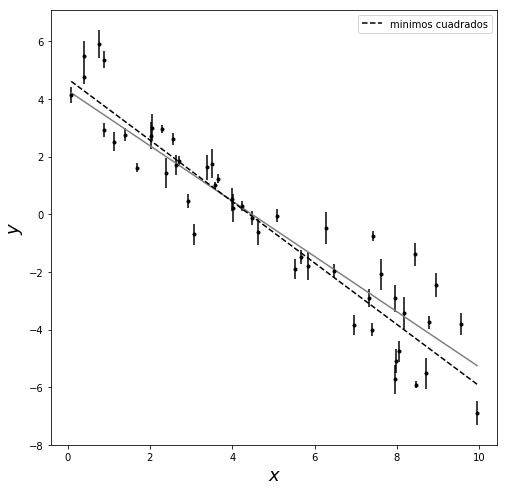

In [57]:
X_ls = np.linspace(np.amin(x),np.amax(x))
Y_ls = m_ls*X_ls + b_ls
plt.figure(figsize=(8,8))
plt.xlabel('$x$',fontsize = 18)
plt.ylabel('$y$',fontsize = 18)
plt.errorbar(x, y, yerr=yerr, color='0' ,fmt=".k")
plt.plot(X0,Y0,color='0.5')
plt.plot(X_ls,Y_ls,'k--',label = 'minimos cuadrados')
plt.legend()
plt.show()

Este no es un resultado irrazonable, pero las incertidumbres en la pendiente y la intersección parecen un poco pequeñas (debido a las pequeñas barras de error en la mayoría de los puntos de datos).

## Estimación del maximo Likelihood 

 la función de probabilidad es:
\begin{equation}
\ln p(y|x,\sigma,m,b,f)=\frac{1}{2} \sum_N \left[\frac{(y_n-mx_m-b)^2}{S_n^2}+ \ln (2 \pi S_n^2) \right]
\end{equation}
donde:
\begin{equation}
S_n^2=\sigma_n^2 + f^2(mx_n+b)^2
\end{equation}

Esta función de probabilidad es simplemente una gaussiana en la que la variación está subestimada por alguna cantidad fraccionaria: $f$. 

In [59]:
def lnlike(theta, x, y, yerr):
    m, b, lnf = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2 + model**2*np.exp(2*lnf))
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))

Una buena manera de encontrar este óptimo numérico de esta función de probabilidad es usar el módulo scipy.optimize:

In [60]:
nll = lambda *args: -lnlike(*args)
result = op.minimize(nll, [m_true, b_true, np.log(f_true)], args=(x, y, yerr))
m_ml, b_ml, lnf_ml = result["x"]

Vale la pena señalar que el módulo de optimización minimiza las funciones, mientras que nos gustaría maximizar la probabilidad. Este objetivo es equivalente a minimizar la probabilidad negativa (o, en este caso, la probabilidad de registro negativa).

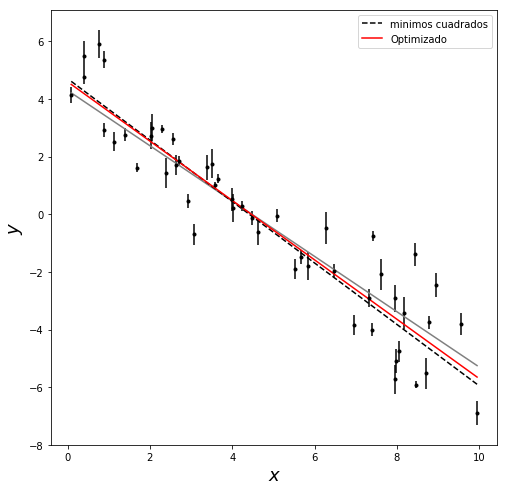

In [63]:
X_ml = np.linspace(np.amin(x),np.amax(x))
Y_ml = m_ml*X_ml + b_ml
plt.figure(figsize=(8,8))
plt.xlabel('$x$',fontsize = 18)
plt.ylabel('$y$',fontsize = 18)
plt.errorbar(x, y, yerr=yerr, color='0' ,fmt=".")
plt.plot(X0,Y0,color='0.5')
plt.plot(X_ls,Y_ls,'k--',label = 'minimos cuadrados')
plt.plot(X_ml,Y_ml,'r-', label = 'Optimizado')
plt.legend()

El resultado de máxima verosimilitud se representa como una línea roja, en comparación con el modelo verdadero (línea gris) y los mínimos cuadrados lineales (línea punteada), en la siguiente figura:

## Minimizacion 

El problema ahora: ¿cómo estimamos las incertidumbres sobre m y b? Además, es probable que no nos importe mucho el valor de f, pero parece que vale la pena propagar cualquier incertidumbre sobre su valor a nuestras estimaciones finales de m y b.

Función de probabilidad posterior:

\begin{equation}
p(m,b,f|x,y,\sigma) \ni p(m,b,f)p(y|x,\sigma,m,b,f)
\end{equation}

donde:

\begin{equation}
p(y|x,\sigma,m,b,f)
\end{equation}

es la funcion likelihood y la funcion "prior" es:

\begin{equation}
p(m,b,f)
\end{equation}

En codigo, el log-prior es:

In [64]:
def lnprior(theta):
    m, b, lnf = theta
    if -5.0 < m < 0.5 and 0.0 < b < 10.0 and -10.0 < lnf < 1.0:
        return 0.0
    return -np.inf

La función log-probabilidad completa es:

In [65]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

Después de toda esta configuración, es fácil muestrear esta distribución utilizando emcee. Comenzaremos inicializando a los 'caminantes' en una pequeña bola gaussiana alrededor del resultado de máxima probabilidad:

In [71]:
ndim, nwalkers = 3, 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

luego, podemos configurar la muestra

In [67]:
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y, yerr))

y ejecute el MCMC durante 500 pasos a partir de la pequeña bola definida anteriormente:

In [68]:
p=sampler.run_mcmc(pos, 500)

Echemos un vistazo a lo que ha hecho la muestra. La mejor manera de ver esto es mirar las series temporales de los parámetros en la cadena. El objeto de muestra ahora tiene un atributo llamado cadena que es una matriz con la forma (100, 500, 3) que proporciona los valores de los parámetros para cada caminante en cada paso de la cadena. La siguiente figura muestra las posiciones de cada caminante en función del número de pasos en la cadena:

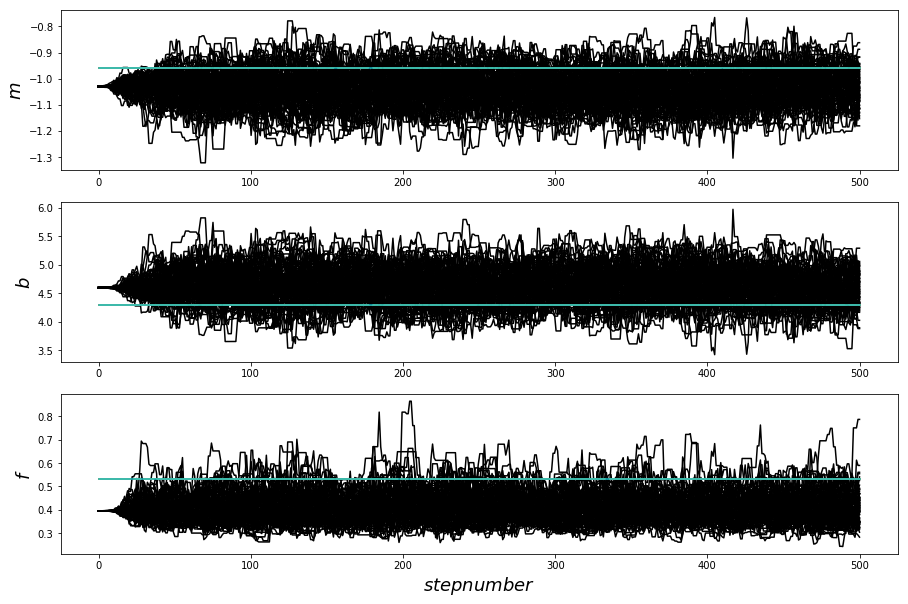

In [72]:
x_g = np.linspace(0.0, 500, 500)
y_m = m_true*np.ones(500)
y_b = b_true*np.ones(500)
y_f = f_true*np.ones(500)

plt.figure(figsize=(15,10))

for i in range(nwalkers):
    
    plt.subplot(3, 1, 1)
    plt.plot(x_g, sampler.chain[i,:,0], '-k')
    plt.plot(x_g, y_m, '-')
    plt.ylabel('$m$',fontsize = 18)

    plt.subplot(3, 1, 2)
    plt.plot(x_g, sampler.chain[i,:,1], '-k')
    plt.plot(x_g, y_b, '-')
    plt.ylabel('$b$',fontsize = 18)

    plt.subplot(3, 1, 3)
    plt.plot(x_g, np.exp(sampler.chain[i,:,2]), '-k')
    plt.plot(x_g, y_f, '-')
    plt.xlabel('$stepnumber$',fontsize = 18)
    plt.ylabel('$f$',fontsize = 18)

plt.show()



Los valores reales de los parámetros se indican como líneas azul en la parte superior de las muestras. Como se mencionó anteriormente, los caminantes comienzan en pequeñas distribuciones alrededor de los valores de máxima verosimilitud y luego vagan rápidamente y comienzan a explorar la distribución posterior completa. De hecho, después de menos de 50 pasos, las muestras parecen bastante bien "quemadas". Esa es una afirmación difícil de hacer cuantitativamente, pero por ahora, simplemente la aceptaremos y descartaremos los 50 pasos iniciales y aplanaremos la cadena para que tengamos una lista plana de muestras:

In [70]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

## Resultados

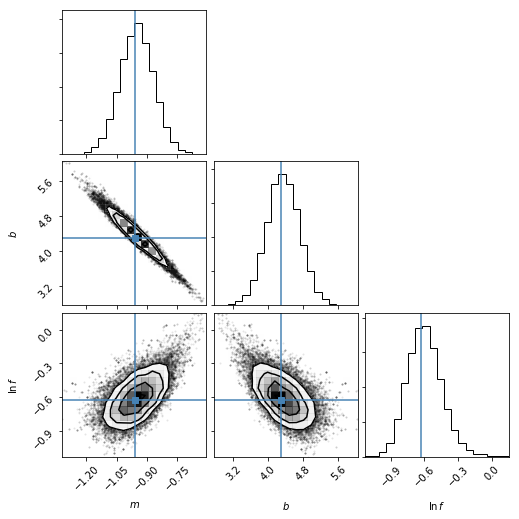

In [41]:
fig = corner.corner(samples, labels=["$m$", "$b$", "$\ln\,f$"],
                      truths=[m_true, b_true, np.log(f_true)])
fig.savefig("triangle.png")

La gráfica de la esquina muestra todas las proyecciones unidimensionales y bidimensionales de las distribuciones de probabilidad posteriores de sus parámetros. Esto es útil porque demuestra rápidamente todas las covarianzas entre los parámetros. Además, la forma en que encuentre la distribución marginal para un parámetro o conjunto de parámetros utilizando los resultados de la cadena MCMC es proyectar las muestras en ese plano y luego hacer un histograma de N dimensiones. Eso significa que la gráfica de la esquina muestra la distribución marginalizada para cada parámetro de forma independiente en los histogramas a lo largo de la diagonal y luego las distribuciones bidimensionales marginadas en los otros paneles.


Otra gráfica de diagnóstico es la proyección de sus resultados en el espacio de los datos observados. Para hacer esto, puede elegir algunas muestras (digamos 100 en este caso) de la cadena y trazarlas sobre los puntos de datos:

<ErrorbarContainer object of 3 artists>

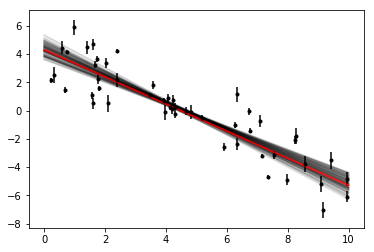

In [44]:
xl = np.array([0, 10])
for m, b, lnf in samples[np.random.randint(len(samples), size=100)]:
    plt.plot(xl, m*xl+b, color="k", alpha=0.1)
plt.plot(xl, m_true*xl+b_true, color="r", lw=2, alpha=0.8)
plt.errorbar(x, y, yerr=yerr, fmt=".k")

In [45]:
samples[:, 2] = np.exp(samples[:, 2])
m_mcmc, b_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                             zip(*np.percentile(samples, [16, 50, 84],
                                                axis=0)))

In [47]:
samples[:,2]

array([1.6658387 , 1.67381316, 1.68476416, ..., 1.64484733, 1.68407732,
       1.67675411])